In [1]:
import numpy as np 
import pandas as pd 
import io
from scipy import stats
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
%matplotlib inline  
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [5]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
character_col_names = []
for y in train_df.columns:
    if(train_df[y].dtype != np.float64 and train_df[y].dtype != np.int64):
          character_col_names.append(y)
character_col_names

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [8]:
len(character_col_names)

43

In [9]:
numeric_col_names = []
for i in train_df.columns:
    if i not in character_col_names:
        numeric_col_names.append(i)

In [10]:
len(numeric_col_names)

38

### There are 43 character features and 38 numerical features.

In [11]:
train_df.isnull().any(axis = 0).sum()

19

### There are 19 columns with missing values.

C:\Users\denni\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

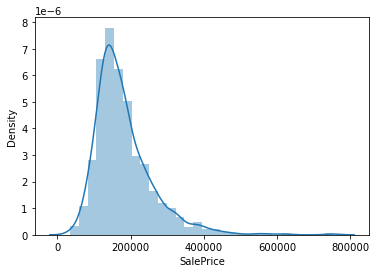

In [12]:
sns.distplot(train_df["SalePrice"],bins=30)


### We can see that SalePrice is slightly right-skewed given that there are fewer houses with higher sale price.

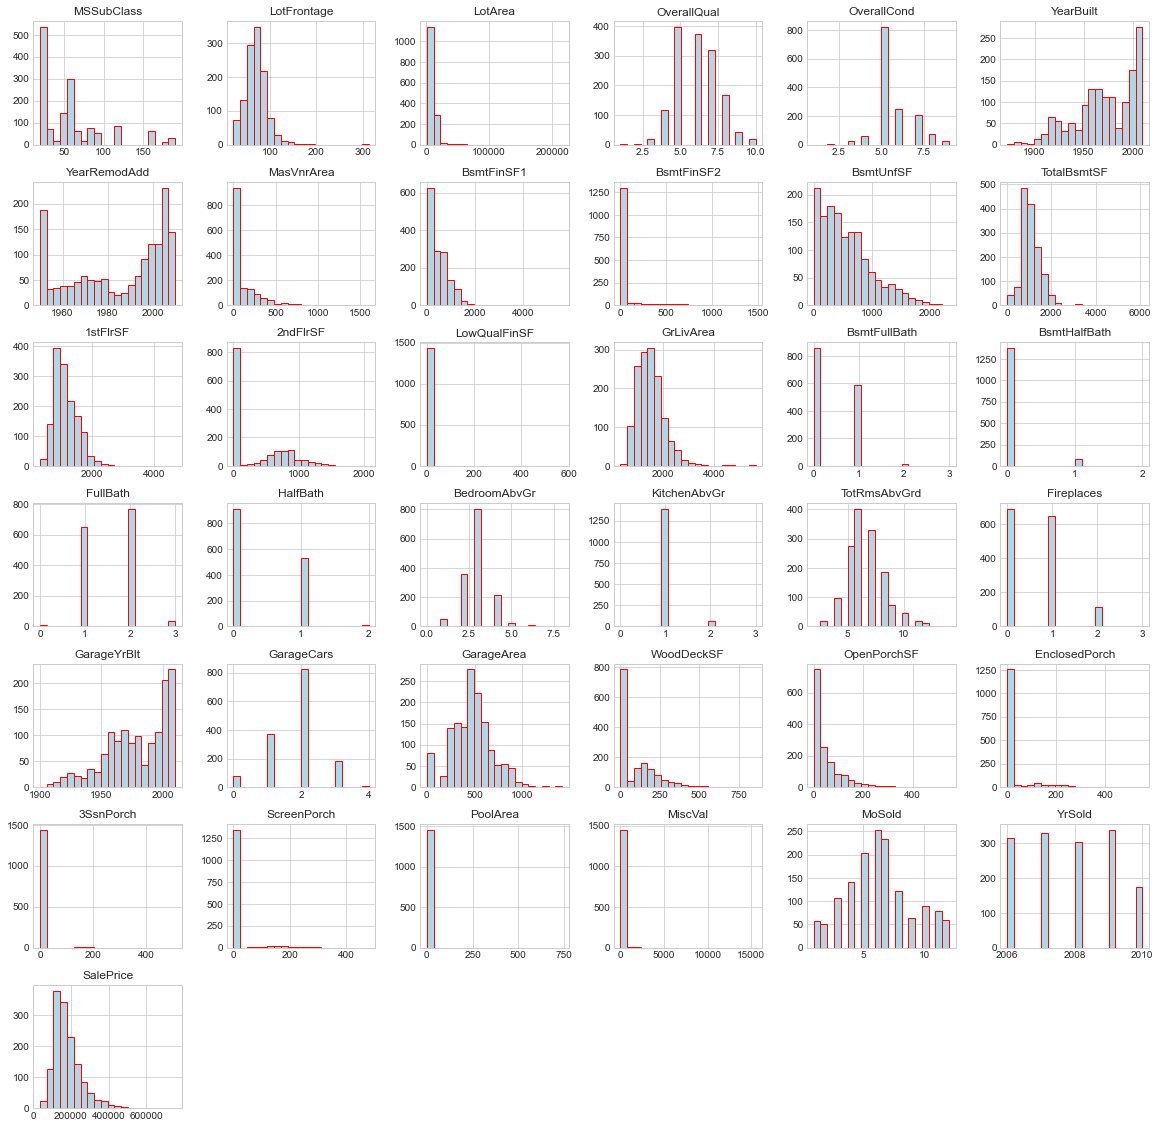

In [13]:
plt.style.use('seaborn-whitegrid')

train_df.iloc[:,1:].hist(bins=20, figsize=(20,20), color='lightblue', edgecolor = 'red')
plt.show()

### Before we look at categorical values, let's take a look at correlations between SalePrice and numerical features.

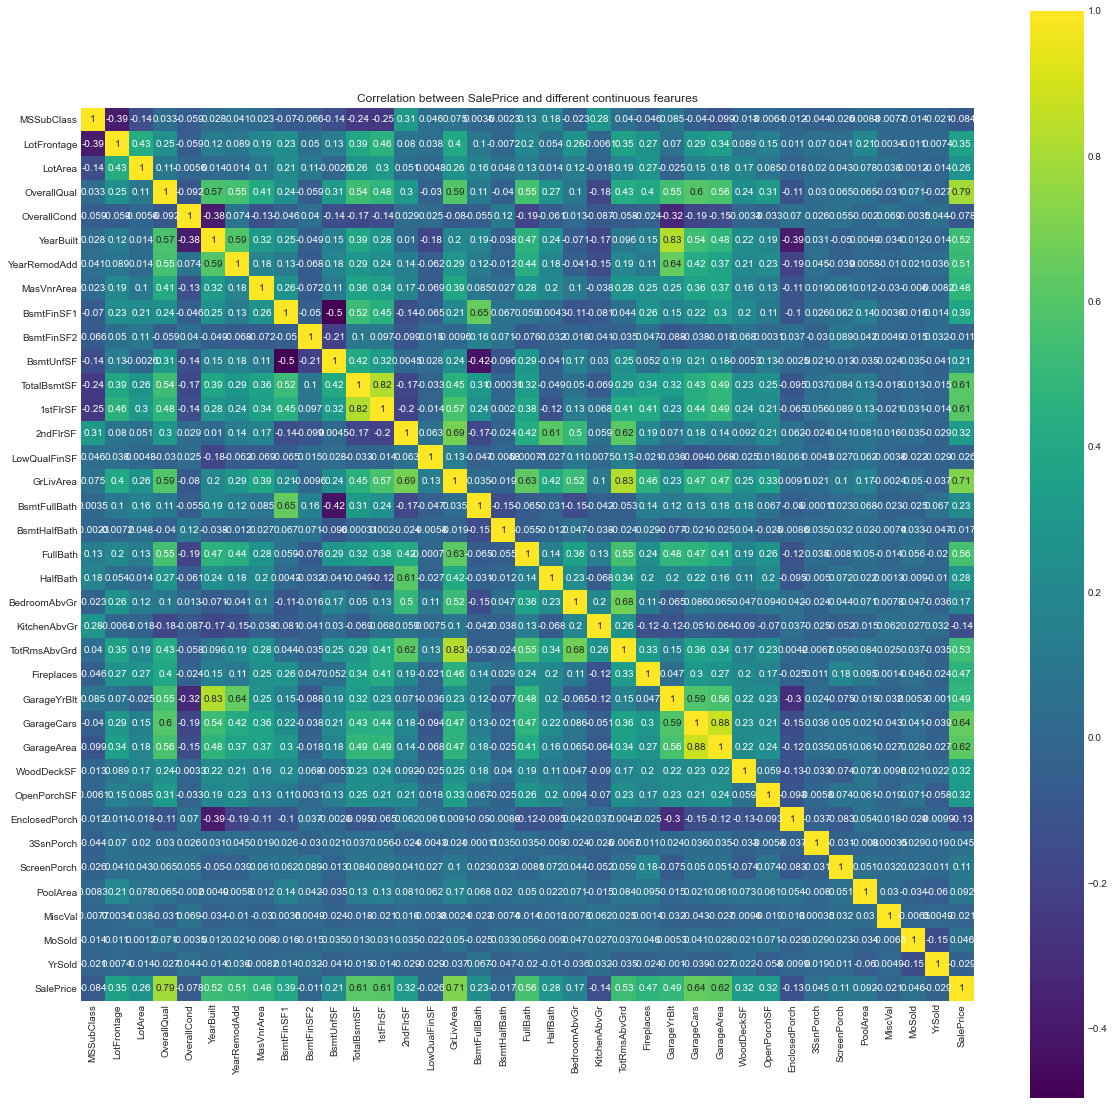

In [14]:
def correlation_heatmap(dataframe,l,w):
    corr = dataframe.corr()
    
    plt.figure(figsize=(l,w))
    sns.heatmap(corr, vmax=1, square=True,annot=True,cmap='viridis')
    
    plt.title('Correlation between SalePrice and different continuous fearures')
    plt.show();
    
cleandf = train_df.iloc[:,1:]
correlation_heatmap(cleandf, 20,20)

### Features that has highest correlations with SalePrice  are OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF, FullBath, TotRmsAbvGrd, YearBuilt, YearRemodAdd.

### Let's plot some of the features to see how it relates with SalePrice.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10')])

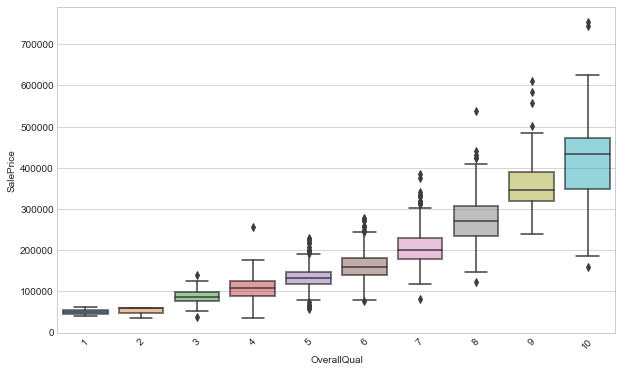

In [15]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='OverallQual', y='SalePrice', data=train_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

### As expected, we can see that SalePrice increases as overall quality increases.

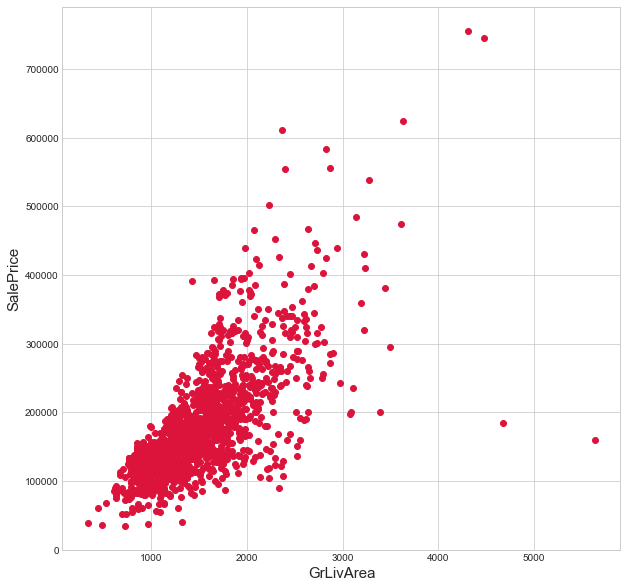

In [16]:
plt.figure(figsize=(10,10))
plt.scatter(train_df['GrLivArea'], train_df['SalePrice'], c='crimson')

plt.xlabel('GrLivArea', fontsize=15)
plt.ylabel('SalePrice', fontsize=15)
plt.show()

### Bigger above ground living area in square feet tends to have higher SalePrice.

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

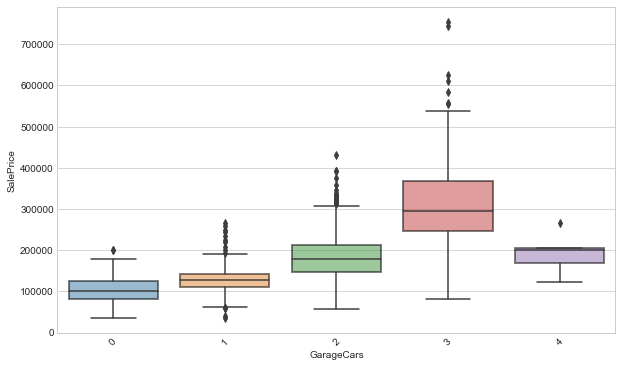

In [17]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='GarageCars', y='SalePrice', data=train_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

### We can see that SalePrice generally increases until the size of garage in car capacity is 3.

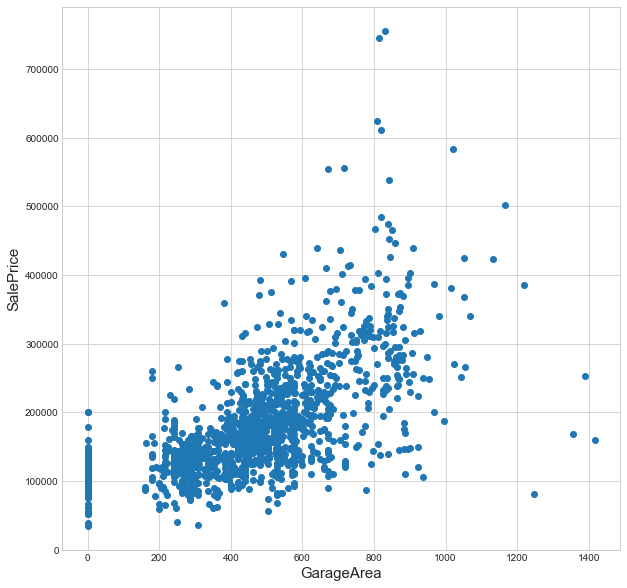

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(train_df['GarageArea'], train_df['SalePrice'])

plt.xlabel('GarageArea', fontsize=15)
plt.ylabel('SalePrice', fontsize=15)
plt.show()

### Although there are some outliers, SalePrice increases with size of garage in square feet.

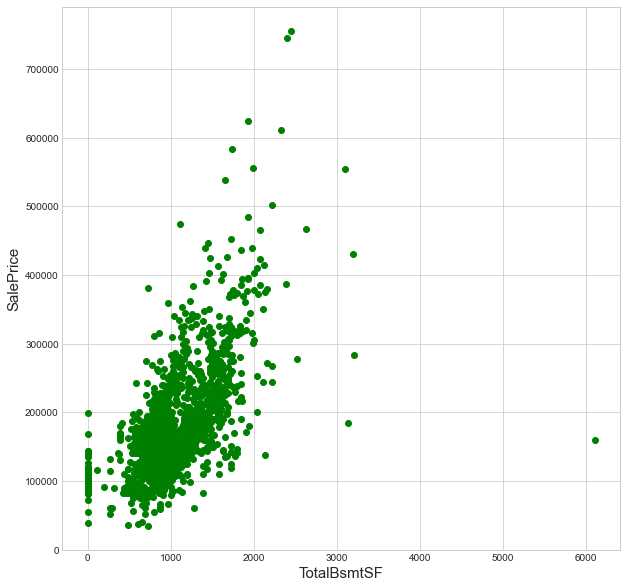

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(train_df['TotalBsmtSF'], train_df['SalePrice'],c='green')

plt.xlabel('TotalBsmtSF', fontsize=15)
plt.ylabel('SalePrice', fontsize=15)
plt.show()

### Similar to ground area feature, higher total square feet of basement area leads to higher SalePrice.

### Let's start to impute missing values. If a feature is ordinal, I will  label encode the feature. 

In [20]:
train_df['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [21]:
train_df['Alley'] = train_df['Alley'].fillna('None')

In [22]:
train_df['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [23]:
train_df['MasVnrType'] = train_df['MasVnrType'].fillna('None')          

In [24]:
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(0)          

In [25]:
train_df['MiscFeature'].value_counts()

Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

In [26]:
train_df['MiscFeature'] = train_df['MiscFeature'].fillna('None')          

In [27]:
train_df['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [28]:
train_df['Fence'] = train_df['Fence'].fillna('None')          

In [29]:
train_df['PoolQC'].value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [30]:
train_df['PoolQC'] = train_df['PoolQC'].fillna('None')          

In [31]:
qual_mapping = {'None': 0, 'Po': 1,'Fa': 2,'TA': 3,'Gd': 4,'Ex': 5}

train_df = train_df.replace({'PoolQC': qual_mapping})

In [32]:
train_df['PoolQC'].value_counts()

0    1453
4       3
5       2
2       2
Name: PoolQC, dtype: int64

In [33]:
train_df['FireplaceQu'].value_counts()       

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [34]:
train_df['FireplaceQu'] = train_df['FireplaceQu'].fillna('None')          

In [35]:
train_df = train_df.replace({'FireplaceQu': qual_mapping})

In [36]:
train_df['Electrical'].value_counts()       

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [37]:
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])          

<AxesSubplot:>

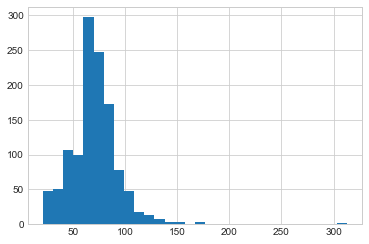

In [38]:
train_df['LotFrontage'].hist(bins=30)

In [39]:
# later change to median per Neighborhood median
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(train_df['LotFrontage'].median())          

In [40]:
train_df['BsmtQual'].value_counts()       

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [41]:
train_df['BsmtCond'].value_counts()       

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [42]:
train_df['BsmtExposure'].value_counts()       

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [43]:
train_df['BsmtFinType1'].value_counts()       

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [44]:
train_df['BsmtFinType2'].value_counts()       

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [45]:
train_df['BsmtQual'] = train_df['BsmtQual'].fillna('None')
train_df['BsmtCond'] = train_df['BsmtCond'].fillna('None')
train_df['BsmtExposure'] = train_df['BsmtExposure'].fillna('None')
train_df['BsmtFinType1'] = train_df['BsmtFinType1'].fillna('None')
train_df['BsmtFinType2'] = train_df['BsmtFinType2'].fillna('None')

In [46]:
train_df = train_df.replace({'BsmtQual': qual_mapping})
train_df = train_df.replace({'BsmtCond': qual_mapping})

In [47]:
Bsmt_exposure_mapping = {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
train_df = train_df.replace({'BsmtExposure': Bsmt_exposure_mapping})

In [48]:
Bsmt_finType_mapping = {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
train_df = train_df.replace({'BsmtFinType1': Bsmt_finType_mapping})
train_df = train_df.replace({'BsmtFinType2': Bsmt_finType_mapping})

In [49]:
train_df['BsmtFinType2'].value_counts()       

1    1256
3      54
2      46
0      38
4      33
5      19
6      14
Name: BsmtFinType2, dtype: int64

In [50]:
train_df['BsmtCond'].value_counts()       

3    1311
4      65
2      45
0      37
1       2
Name: BsmtCond, dtype: int64

In [51]:
# numeric_col_names
# character_col_names
train_df[character_col_names].isnull().sum()

MSZoning          0
Street            0
Alley             0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
MasVnrType        0
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual          0
BsmtCond          0
BsmtExposure      0
BsmtFinType1      0
BsmtFinType2      0
Heating           0
HeatingQC         0
CentralAir        0
Electrical        0
KitchenQual       0
Functional        0
FireplaceQu       0
GarageType       81
GarageFinish     81
GarageQual       81
GarageCond       81
PavedDrive        0
PoolQC            0
Fence             0
MiscFeature       0
SaleType          0
SaleCondition     0
dtype: int64

In [52]:
train_df['GarageType'].value_counts()       

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [53]:
train_df['GarageFinish'].value_counts()       

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

In [54]:
train_df['GarageQual'].value_counts()       

TA    1311
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64

In [55]:
train_df['GarageCond'].value_counts()       

TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [56]:
train_df['GarageType'] = train_df['GarageType'].fillna('None')
train_df['GarageFinish'] = train_df['GarageFinish'].fillna('None')
train_df['GarageQual'] = train_df['GarageQual'].fillna('None')
train_df['GarageCond'] = train_df['GarageCond'].fillna('None')

In [57]:
train_df = train_df.replace({'GarageQual': qual_mapping})

In [58]:
train_df = train_df.replace({'GarageCond': qual_mapping})

In [59]:
train_df['GarageCond'].value_counts()       

3    1326
0      81
2      35
4       9
1       7
5       2
Name: GarageCond, dtype: int64

In [60]:
#GarageYrBlt       81

In [61]:
train_df = train_df.replace({'ExterCond': qual_mapping})

In [62]:
train_df = train_df.replace({'ExterQual': qual_mapping})

In [63]:
func_mapping = {'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7}
train_df = train_df.replace({'Functional': func_mapping})

In [64]:
train_df = train_df.replace({'KitchenQual': qual_mapping})

In [65]:
lotShape_mapping = {'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3}
train_df = train_df.replace({'LotShape': lotShape_mapping})

In [66]:
train_df = train_df.replace({'HeatingQC': qual_mapping})

In [67]:
street_mapping = {'Grvl':0, 'Pave':1}
train_df = train_df.replace({'Street': street_mapping})

In [68]:
PavedDrive_mapping = {'N':0, 'P':1, 'Y':2}
train_df = train_df.replace({'PavedDrive': PavedDrive_mapping})

In [69]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   int64  
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   int64  
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Let's plot correlations again to see if there is any difference.

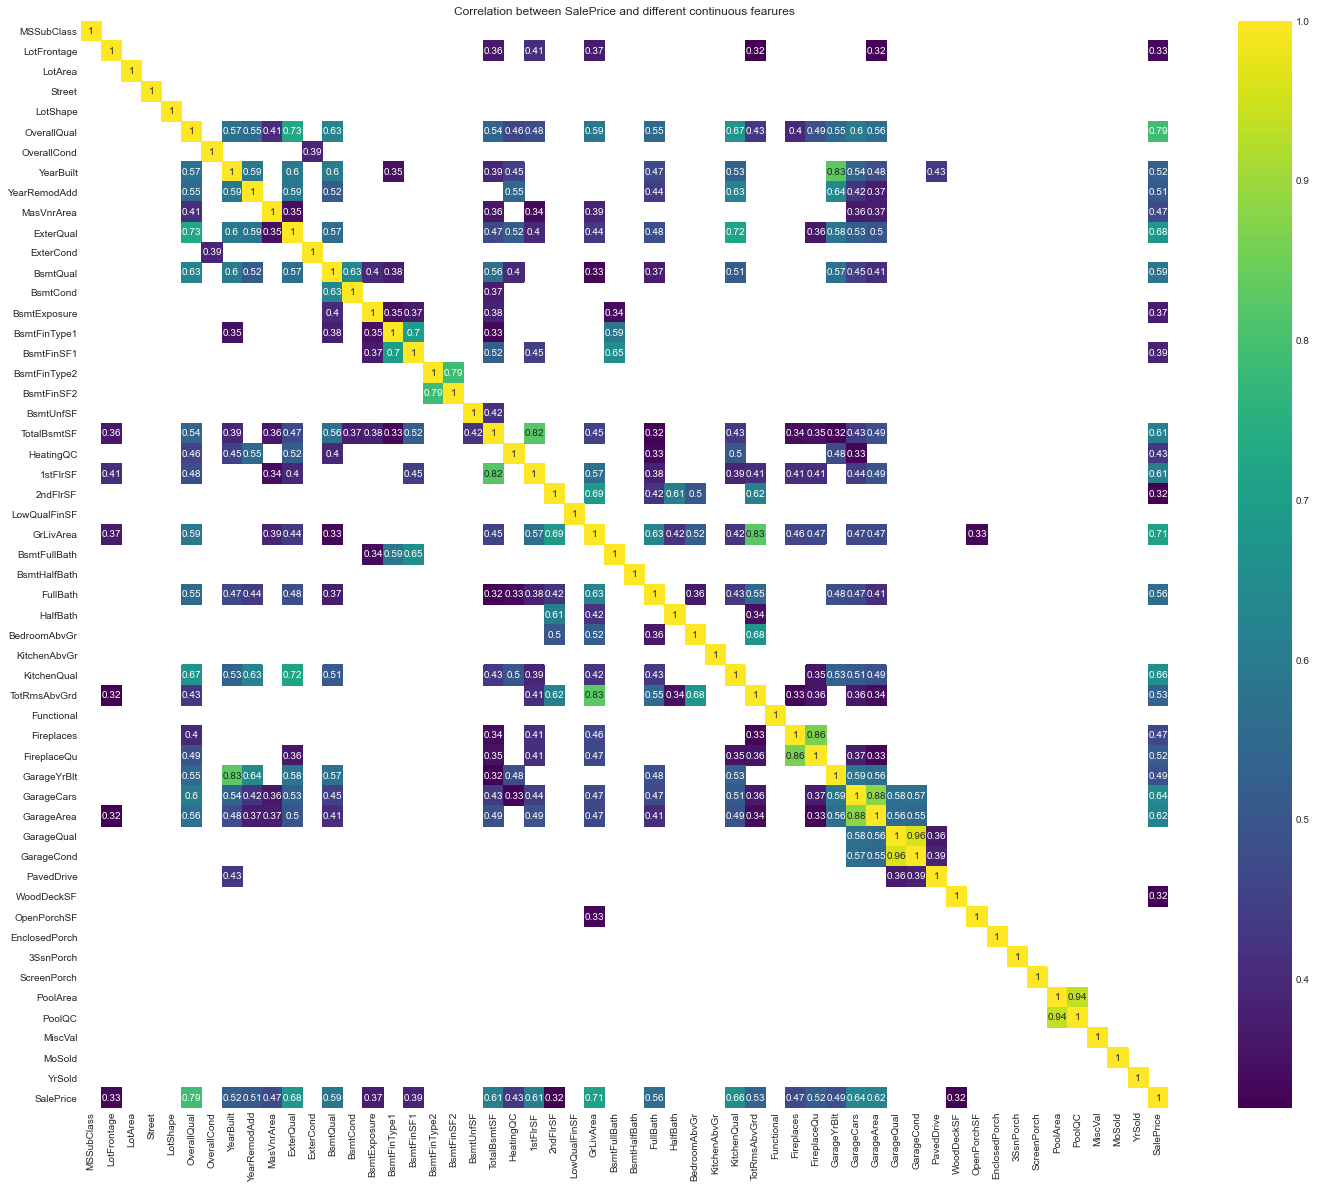

In [70]:
def correlation_heatmap(dataframe,l,w):
    corr = dataframe.corr()
    
    plt.figure(figsize=(l,w))
    sns.heatmap(corr.stack(dropna=False).nlargest(400).unstack(), square=True, vmax=1,annot=True,cmap='viridis')
    
    plt.title('Correlation between SalePrice and different continuous fearures')
    plt.show();
    
cleandf = train_df.iloc[:,1:]
correlation_heatmap(cleandf, 25,20)

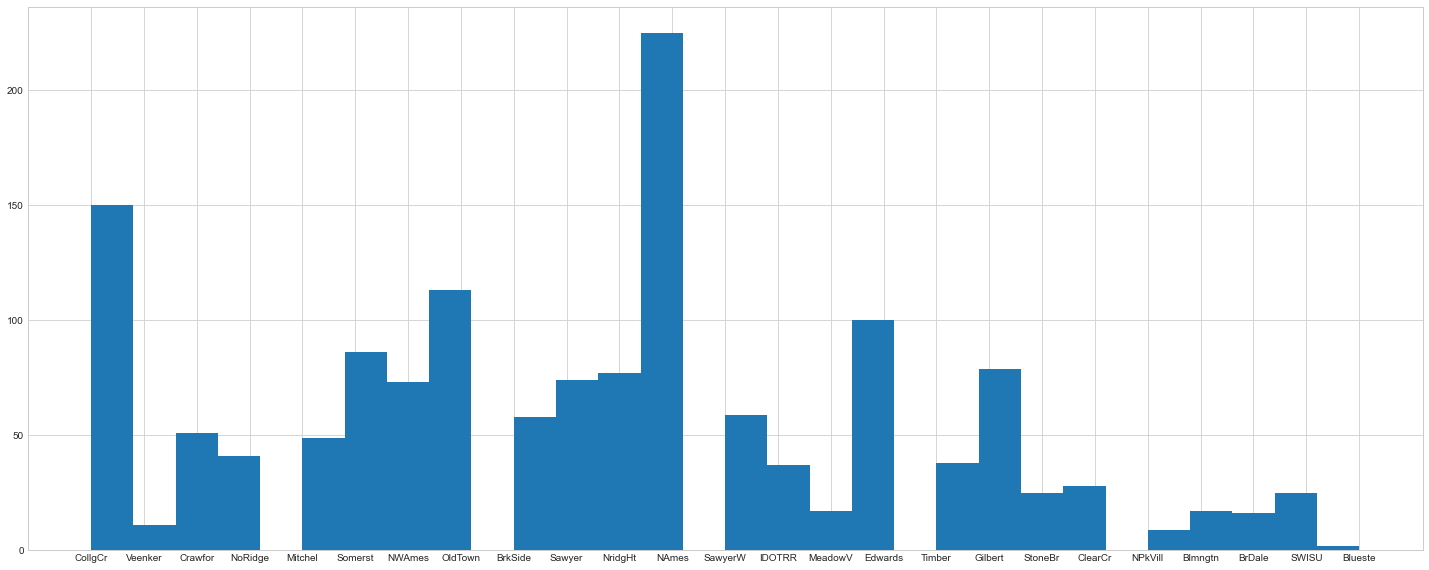

In [71]:
plt.figure(figsize=(25,10))
train_df['Neighborhood'].hist(bins=30)
plt.show()

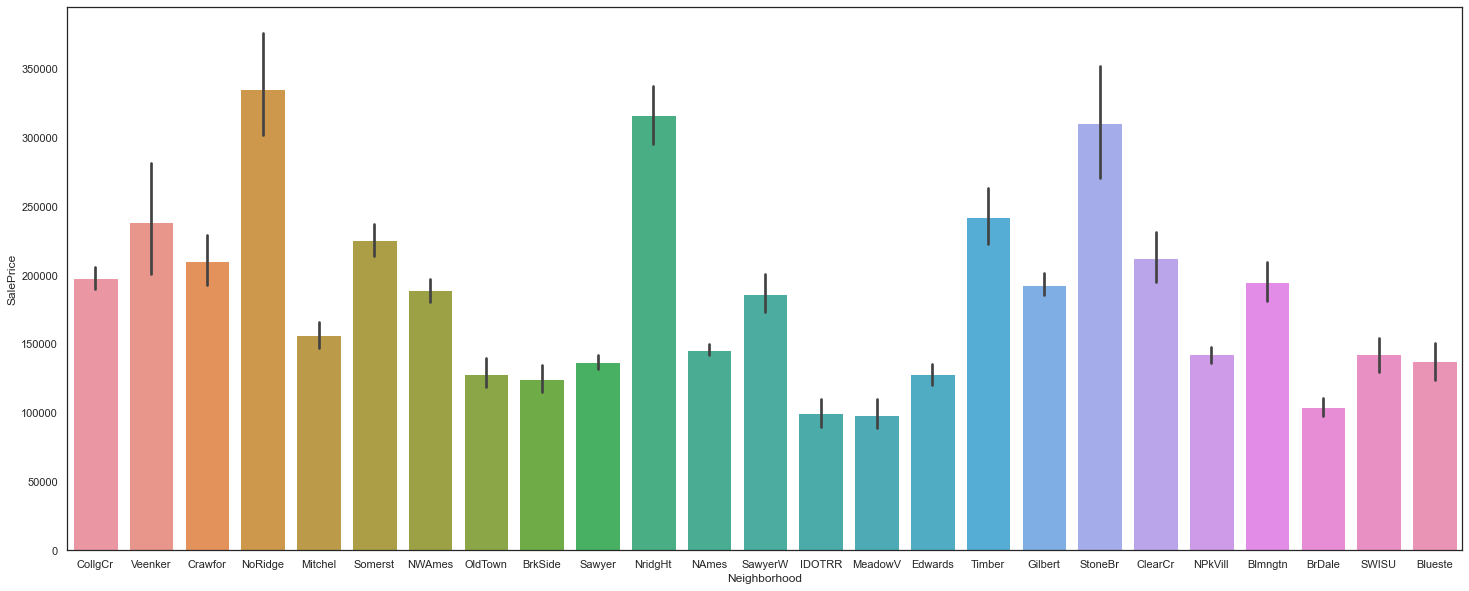

In [72]:
plt.figure(figsize=(25,10))
sns.set_theme(style="white")
ax = sns.barplot(x="Neighborhood", y="SalePrice", data=train_df)
plt.show()

(array([0, 1, 2, 3]),
 [Text(0, 0, '2'), Text(1, 0, '3'), Text(2, 0, '4'), Text(3, 0, '5')])

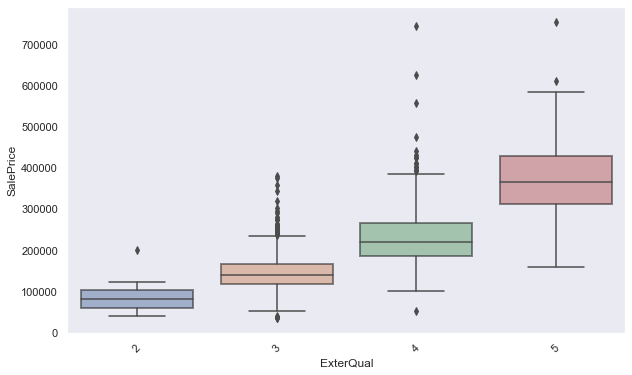

In [79]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='ExterQual', y='SalePrice', data=train_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

(array([0, 1, 2, 3]),
 [Text(0, 0, '2'), Text(1, 0, '3'), Text(2, 0, '4'), Text(3, 0, '5')])

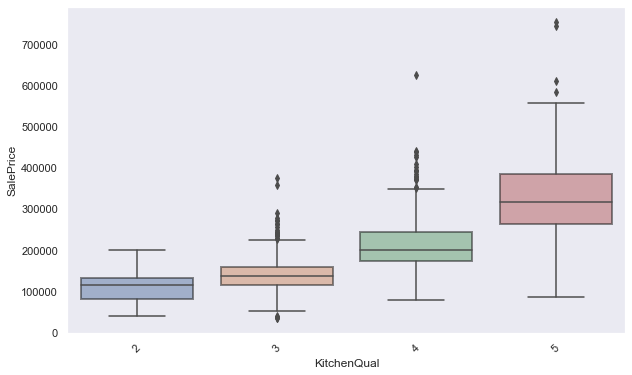

In [80]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='KitchenQual', y='SalePrice', data=train_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'RL'),
  Text(1, 0, 'RM'),
  Text(2, 0, 'C (all)'),
  Text(3, 0, 'FV'),
  Text(4, 0, 'RH')])

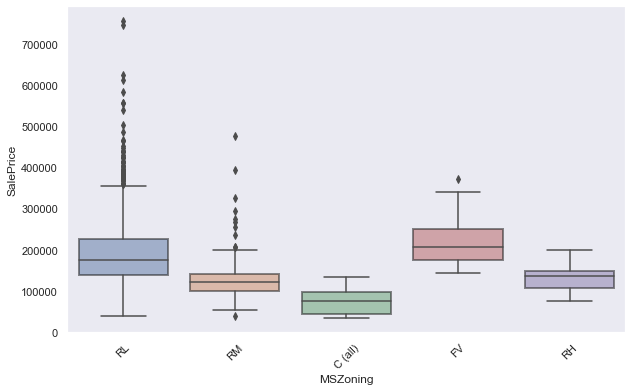

In [81]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='MSZoning', y='SalePrice', data=train_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)